In [1]:
%matplotlib inline
import time
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy import io
import pickle

# Own code
sys.path.append("../")
from utils.data_utils import generate_contemp_matrices, transformation, standardize
from utils.tvp_models import TVPVARModel, tvp_ar_contemp, tvp_ar_non_contemp

# Suppress scientific notation in numpy
np.set_printoptions(suppress=False)

In [2]:
# Set M and standardization

M = 3
standardization = False
transform = True

In [3]:
ds = pd.read_csv("../data/fred_qd.csv")
gdp = transformation(ds["GDPC1"].iloc[2:].to_numpy(), 5, transform, scale=1)
cpi = transformation(ds["CPIAUCSL"].iloc[2:].to_numpy(), 6, transform, scale=1)
fedfund = transformation(ds["FEDFUNDS"].iloc[2:].to_numpy(), 2, transform, scale=1)
compi = transformation(ds["PPIACO"].iloc[2:].to_numpy(), 6, transform, scale=1)
borrowings = transformation(ds["TOTRESNS"].iloc[2:].to_numpy(), 6, transform, scale=1)
sp500 = transformation(ds["S&P 500"].iloc[2:].to_numpy(), 5, transform, scale=1)
m2 = transformation(ds["M2REAL"].iloc[2:].to_numpy(), 5, transform, scale=1)

# Start due to transformation

lag = 1

if M == 3:

    series = [gdp[lag:], cpi[lag:], fedfund[lag:]]
    
elif M == 7:
    
    series = [gdp[lag:], cpi[lag:], fedfund[lag:],compi[lag:],borrowings[lag:],sp500[lag:],m2[lag:]]
    

if standardization:
    
    series = standardize(series, train = 243-25)

series_total = np.array(series)

y_matrix_contemp, X_matrix_contemp = generate_contemp_matrices(244, M, 1, series_total)

# Lasso 

In [ ]:
# Check if the model, given the specific data, converges at all

T = 243
p = 1
prior = "lasso_alternative"
train = T - 25

msfe, alpl, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=True, iterations=100)

### Parameter -> $a_{0}$

In [ ]:
def calculate_derivative_lasso_a0(iteration, parameter_value):
    
    prior = "lasso_alternative"
    T = 243
    p = 1
    train = T-25
    iterations = 100

    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0_lasso":parameter_value+error,"b0_lasso":1e-3}
    prior_parameters_minus = {"a0_lasso":parameter_value-error,"b0_lasso":1e-3}
    
    msfe_plus, *_, y_pred_plus, msfe_complete_plus = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_, y_pred_minus, msfe_complete_minus= tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative_complete = (msfe_complete_plus.mean(0) - msfe_complete_minus.mean(0))/(2*error)
    derivative_msfe = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    derivative_h_step = (msfe_plus - msfe_minus)/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative_complete}')
    
    return [parameter_value, derivative_complete, derivative_msfe, derivative_h_step]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1e-3
finish = 2
interval = 256

a0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_lasso_a0, a0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 256) 

spl = make_interp_spline(result[:,0], result[:,3], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "lasso_alternative"
parameter = "a0_lasso"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}_vb_based.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

### Parameter -> $b_{0}$

In [ ]:
def calculate_derivative_lasso_b0(iteration, parameter_value):
    
    prior = "lasso_alternative"
    T = 243
    p = 1
    train = T-25
    iterations = 75
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0_lasso":1e-3,"b0_lasso":parameter_value+error}
    prior_parameters_minus = {"a0_lasso":1e-3,"b0_lasso":parameter_value-error}
    
    msfe_plus, *_, y_pred_plus, msfe_complete_plus = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_, y_pred_minus, msfe_complete_minus= tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative_complete = (msfe_complete_plus.mean(0) - msfe_complete_minus.mean(0))/(2*error)
    derivative_msfe = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    derivative_h_step = (msfe_plus - msfe_minus)/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative_complete}')
    
    return [parameter_value, derivative_complete, derivative_msfe, derivative_h_step]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1e-3
finish = 0.5
interval = 256

b0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_lasso_b0, b0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 528) 

spl = make_interp_spline(result[:,0], result[:,3], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "lasso_alternative"
parameter = "b0_lasso"
start = 1e-3
finish = 0.5
interval = 64

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}_vb_based.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

# SVSS

In [ ]:
# Check if the model, given the specific data, converges at all

T = 243
p = 1
prior = "svss"

train = T - 25

prior_paramters = {"g0":1e-2,"h0":1e-2,"pi0":0.5}

msfe, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=True, iterations=75, prior_parameters=prior_paramters)

### Parameter -> $g_{0}$

In [5]:
def calculate_derivative_svss_g0(iteration, parameter_value):
    
    prior = "svss"
    T = 243
    p = 1
    train = T-25
    iterations = 75
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"g0":parameter_value+error,"h0":1e-2, "pi0":0.5}
    prior_parameters_minus = {"g0":parameter_value-error,"h0":1e-2, "pi0":0.5}
    
    msfe_plus, *_, y_pred_plus, msfe_complete_plus = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_, y_pred_minus, msfe_complete_minus= tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative_complete = (msfe_complete_plus.mean(0) - msfe_complete_minus.mean(0))/(2*error)
    derivative_msfe = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    derivative_h_step = (msfe_plus - msfe_minus)/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative_complete}')
    
    return [parameter_value, derivative_complete, derivative_msfe, derivative_h_step]

In [22]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1e-2
finish = 1e-1
interval = 128

g0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_svss_g0, g0_set)

Run: 31 -> Derivative: [ 5.57347500e-08 -2.86913030e-09  1.45527318e-04]
Run: 29 -> Derivative: [ 6.03297519e-08 -2.88479802e-09  1.46771122e-04]
Run: 25 -> Derivative: [ 6.10175162e-08 -2.91581041e-09  1.48847546e-04]
Run: 27 -> Derivative: [ 6.00251198e-08 -2.90014269e-09  1.47801891e-04]
Run: 23 -> Derivative: [ 6.10772796e-08 -2.93163964e-09  1.49909079e-04]
Run: 21 -> Derivative: [ 6.09109111e-08 -2.94763041e-09  1.50983513e-04]
Run: 19 -> Derivative: [ 6.15101609e-08 -2.96345964e-09  1.52070849e-04]
Run: 17 -> Derivative: [ 6.10714648e-08 -2.97977345e-09  1.53171417e-04]
Run: 15 -> Derivative: [ 6.25797651e-08 -2.99592574e-09  1.54285878e-04]
Run: 13 -> Derivative: [ 7.18356703e-08 -3.01240107e-09  1.55413902e-04]
Run: 11 -> Derivative: [ 7.18427773e-08 -3.02887640e-09  1.56556811e-04]
Run: 9 -> Derivative: [ 7.43173073e-08 -3.04567477e-09  1.57714276e-04]
Run: 5 -> Derivative: [ 7.34156867e-08 -3.07943305e-09  1.60087096e-04]
Run: 7 -> Derivative: [ 5.82267245e-08 -3.06247315e-0

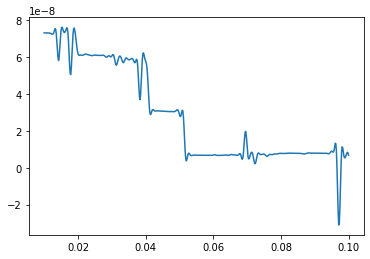

In [32]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 528) 

spl = make_interp_spline(result[:,0], result[:,1], k=3)  # type: BSpline+
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [8]:
prior = "svss"
parameter = "g0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}_vb_based.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

### Parameter -> $h_{0}$

In [ ]:
def calculate_derivative_svss_h0(iteration, parameter_value):
    
    prior = "svss"
    T = 243
    p = 1
    train = T-25
    iterations = 75
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"g0":1e-2,"h0":parameter_value+error, "pi0":0.5}
    prior_parameters_minus = {"g0":1e-2,"h0":parameter_value-error, "pi0":0.5}
    
    msfe_plus, *_, y_pred_plus, msfe_complete_plus = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_, y_pred_minus, msfe_complete_minus= tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative_complete = (msfe_complete_plus.mean(0) - msfe_complete_minus.mean(0))/(2*error)
    derivative_msfe = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    derivative_h_step = (msfe_plus - msfe_minus)/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative_complete}')
    
    return [parameter_value, derivative_complete, derivative_msfe, derivative_h_step]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1e-2
finish = 1.5e-2
interval = 64

h0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_svss_h0, h0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

threshold = 64

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:threshold,0].min(), result[:threshold,0].max(), 528)

spl = make_interp_spline(result[:threshold,0], result[:threshold,1], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "svss"
parameter = "h0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}_std.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

# Horseshoe

In [ ]:
# Check if the model, given the specific data, converges at all

T = 243
p = 1
prior = "horseshoe"
train = T - 25

prior_parameters = {"a0":5, "b0":1}

msfe, *_ = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=True, iterations=100, prior_parameters=prior_parameters)

### Parameter -> $a_{0}$

In [ ]:
def calculate_derivative_horseshoe_a0(iteration, parameter_value):
    
    prior = "horseshoe"
    T = 243
    p = 1
    train = T-25
    iterations = 150
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0":parameter_value+error,"b0":1}
    prior_parameters_minus = {"a0":parameter_value-error,"b0":1}
    
    msfe_plus, *_, y_pred_plus, msfe_complete_plus = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_, y_pred_minus, msfe_complete_minus= tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative_complete = (msfe_complete_plus.mean(0) - msfe_complete_minus.mean(0))/(2*error)
    derivative_msfe = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    derivative_h_step = (msfe_plus - msfe_minus)/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative_complete}')
    
    return [parameter_value, derivative_complete, derivative_msfe, derivative_h_step]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 4
finish = 5
interval = 256

a0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_horseshoe_a0, a0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 528) 

spl = make_interp_spline(result[:,0], result[:,1], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "horseshoe"
parameter = "a0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}_vb_based.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)

### Parameter -> $b_{0}$

In [ ]:
def calculate_derivative_horseshoe_b0(iteration, parameter_value):
    
    prior = "horseshoe"
    T = 243
    p = 1
    train = T-25
    iterations = 100
    
    error = np.sqrt(1.1e-16)
    prior_parameters_plus = {"a0":4,"b0":parameter_value+error}
    prior_parameters_minus = {"a0":4,"b0":parameter_value-error}
    
    msfe_plus, *_, y_pred_plus, msfe_complete_plus = tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_plus)
    msfe_minus, *_, y_pred_minus, msfe_complete_minus= tvp_ar_contemp(T, M, p, train, X_matrix_contemp, y_matrix_contemp, prior, print_status=False, iterations=iterations, prior_parameters=prior_parameters_minus)
    
    derivative_complete = (msfe_complete_plus.mean(0) - msfe_complete_minus.mean(0))/(2*error)
    derivative_msfe = (msfe_plus.mean() - msfe_minus.mean())/(2*error)
    derivative_h_step = (msfe_plus - msfe_minus)/(2*error)
    
    print(f'Run: {iteration+1} -> Derivative: {derivative_complete}')
    
    return [parameter_value, derivative_complete, derivative_msfe, derivative_h_step]

In [ ]:
%%time
import time
import os
from multiprocessing import Pool, Array

# They are going to be some disgusting warnings for the first iterations of the model (has to do with initialization)
import warnings
warnings.filterwarnings("ignore")

# Set seed
np.random.seed(12345)

start = 1
finish = 1.25
interval = 256

b0_set = [(i,value) for i, value in enumerate(np.linspace(start, finish, interval))]

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.starmap(calculate_derivative_horseshoe_b0, b0_set)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

# Visualise the result

result = np.block(derivatives)

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(result[:,0].min(), result[:,0].max(), 528) 

spl = make_interp_spline(result[:,0], result[:,7], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [ ]:
prior = "horseshoe"
parameter = "b0"

dump_to_disk = [derivatives, [xnew, power_smooth]]

with open(f'../sensitivity/results_{M}_{prior}_{parameter}_{start}_{finish}_{interval}_vb_based.pkl"', 'wb') as f:
        pickle.dump(dump_to_disk, f, pickle.HIGHEST_PROTOCOL)